In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

# plt.rc("font", family="serif",) #serif="Times"
# plt.rc("font", family= "Times New Roman")
plt.rc("font", family="serif", serif="Computer Modern")
plt.rc("font", size=SMALL_SIZE)          # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)    # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("text", usetex=true)

In [3]:
function get_quantiles(data, qvals)
    
    qvals = sort(qvals)
    ampvals = sort([data...], rev=true)
    cumsumvals = cumsum(ampvals)
    
    levels_array = []
    
    levels_array = [ampvals[argmin(abs.(cumsumvals .- q))] for q in qvals]
    quantiles_labels = ["$(x*100)\\%" for x in qvals]
    
    sort_ind = sortperm(levels_array)
    
    return levels_array[sort_ind], quantiles_labels[sort_ind]
end

get_quantiles (generic function with 1 method)

In [4]:
FPATH = "../../data/sampling_results/Benchmark-5/"

@load FPATH*"mcmc-summary-data.jld" data_save
data = data_save[1];

In [5]:
charges_n = data.ev_charge ./ maximum(data.ev_charge)
runind_n = data.ev_index ./ maximum(data.ev_index);

In [6]:
rind = 1:length(data.ev_charge)

1:672

In [7]:
charges_n[sortperm(charges_n)] .= 1:length(charges_n)
charges_n = charges_n ./ maximum(charges_n);
charges = data.ev_charge;

## Transversal Size: 

In [55]:
σ_x_halo = data.μx_trsz_halo
σ_y_halo = data.μy_trsz_halo
σ_x_core = data.μx_trsz_core
σ_y_core = data.μy_trsz_core

std_x_halo = data.σx_trsz_halo
std_y_halo = data.σy_trsz_halo
std_x_core = data.σx_trsz_core
std_y_core = data.σy_trsz_core;

In [56]:
sort_ind = sortperm(std_x_halo, rev=true)[1:10]

std_x_halo[sort_ind]

10-element Vector{Float64}:
 0.006474989114431883
 0.005971662987711722
 0.005840760939023388
 0.005730268106590855
 0.005616700858612504
 0.005579483144218378
 0.005571164784347782
 0.005512293040937738
 0.0054381126491505815
 0.005370754264986229

In [57]:
xmin, xmax = 0.02, 0.24
xrange=range(xmin, stop = xmax,length=100)
yrange=range(xmin, stop = xmax,length=100)
xvals = [pdf(truncated(Normal(0.2, 0.04), 0.02, 0.25), x) for x in xrange]
yvals = [pdf(truncated(Normal(0.2, 0.04), 0.02, 0.25), y)  for y in yrange]
z = xvals*yvals';

In [58]:
quantiles_array = [0.0, 0.80, 0.9, 0.95, 0.985, 0.999, 1]

levels, level_labels = get_quantiles(z./sum(z), quantiles_array);

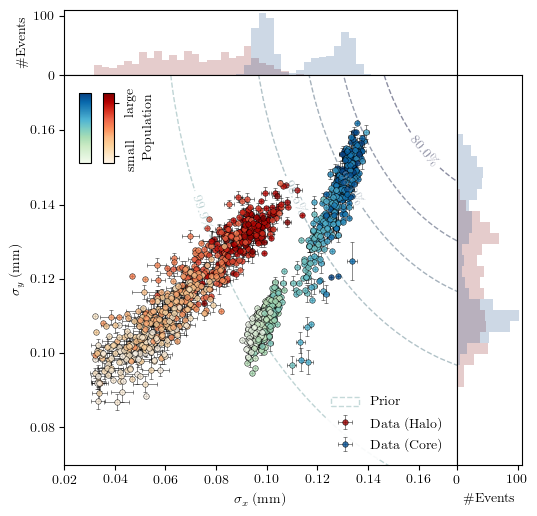

In [59]:
figsize = (5.905631659056317, 5.905631659056317)
# figsize = (7,7)

fig, ax= plt.subplots(2,2, figsize=figsize, gridspec_kw=Dict("width_ratios"=>[6,1], "height_ratios"=>[1,6]))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

colors_tmp = [plt.cm.bone_r(i) for i in range(0.1, stop=0.6, length=length(levels))[2:end]]
cs = ax[2,1].contour(xrange, yrange, z./sum(z), levels=levels, colors=colors_tmp, alpha=0.7, antialiased=true, linewidths=1.0, linestyles="dashed") 


label_1 = "Data (Halo)"
label_2 = "Data (Core)"

errorbar_ind = rind[1]:2:rind[end]
for i in rind[end:-1:1]
    x_err = i in errorbar_ind ? std_x_halo[i] : false
    y_err = i in errorbar_ind ? std_y_halo[i] : false
    ax[2,1].errorbar(σ_x_halo[i], σ_y_halo[i], xerr=x_err, yerr=y_err, 
        color="k", alpha=0.8,
        fmt="o", markersize=4, 
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.4,
        capsize=1.5, ecolor="k", elinewidth=0.4, label=label_1)
    label_1 = ""
    x_err = i in errorbar_ind ? std_x_core[i] : false
    y_err = i in errorbar_ind ? std_y_core[i] : false
    ax[2,1].errorbar(σ_x_core[i], σ_y_core[i], xerr=x_err, yerr=y_err, 
        color="k", alpha=0.8,
        fmt="o", markersize=4,
        mfc=plt.cm.GnBu(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.4, 
        capsize=1.5, ecolor="k", elinewidth=0.4, label=label_2)
    label_2 = ""
end

cb = ax[2,1].scatter(charges_n, charges_n, s=0.0, c=charges, cmap="OrRd")
cb2 = ax[2,1].scatter(charges_n, charges_n, s=0.0, c=charges, cmap="GnBu")
ax_ins_3 = fig.add_axes([0.19,0.62,0.02,0.12])
ax_ins_2 = fig.add_axes([0.15,0.62,0.02,0.12])
cbar = fig.colorbar(cb, spacing="proportional", label="Population", ticks = [10, 25], cax=ax_ins_3)
cbar.ax.set_yticklabels(["small", "large"], rotation=90, verticalalignment="center")  # horizontal colorbar
fig.colorbar(cb2, spacing="proportional", ticks=[], cax=ax_ins_2)

proxy = plt.Rectangle((10, 10), 1, 1, fc="white", color=plt.cm.bone_r(0.17), linewidth=1.0, linestyle="dashed", label="Prior")
# proxy2 = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.Blues(0.57), label="Posterior")
ax[2,1].add_patch(proxy)
# ax[2,1].add_patch(proxy2)
ax[2,1].legend(loc="lower right", framealpha=0.9, edgecolor=:white)

bins_tmp = range(0.02, stop=0.165, length=50)
ax[1,1].hist(σ_x_halo, bins=bins_tmp, color=plt.cm.OrRd(1.), alpha=0.20)
ax[2,2].hist(σ_y_halo, bins=bins_tmp, orientation="horizontal", color=plt.cm.OrRd(1.), alpha=0.2)
ax[1,1].hist(σ_x_core, bins=bins_tmp, color=plt.cm.GnBu(1.), alpha=0.20)
ax[2,2].hist(σ_y_core, bins=bins_tmp, orientation="horizontal", color=plt.cm.GnBu(1.), alpha=0.20)

ax[1,1].set_ylim(bottom=0.0)
ax[2,2].set_xlim(left=0.0)

ax[1,2].set_visible(false)

ax[1,1].set_xticks([])
ax[2,2].set_yticks([])

ax[2,1].set_xlim(0.02, 0.175)
ax[1,1].set_xlim(0.02, 0.175)
ax[2,1].set_ylim(0.07, 0.175)
ax[2,2].set_ylim(0.07, 0.175)

ax[2,1].clabel(cs, fmt = Dict(zip(levels, level_labels)), inline = 1);

ax[2,1].set_xlabel(L"\sigma_x \; (\mathrm{mm})")
ax[2,2].set_xlabel(L"\mathrm{\# Events}")
ax[2,1].set_ylabel(L"\sigma_y \; (\mathrm{mm})")
ax[1,1].set_ylabel(L"\mathrm{\# Events}")

fig.savefig("../../plots/tr-size-m-2.pdf", bbox_inches = "tight")

## Angular Spread: 

In [60]:
σ_x_halo = data.μx_angspr_halo
σ_y_halo = data.μy_angspr_halo
σ_x_core = data.μx_angspr_core
σ_y_core = data.μy_angspr_core

std_x_halo = data.σx_angspr_halo
std_y_halo = data.σy_angspr_halo
std_x_core = data.σx_angspr_core
std_y_core = data.σy_angspr_core;

In [61]:
xmin, xmax = 0, 10
xrange=range(xmin, stop = xmax,length=300)
yrange=range(xmin, stop = xmax,length=300)
xvals = [pdf(Normal(4, 2), x) for x in xrange]
yvals = [pdf(Normal(4, 2), y)  for y in yrange]
z = xvals*yvals';

In [62]:
quantiles_array = [0.0, 0.15, 0.68, 0.9, 0.95, 0.999,1]

levels, level_labels = get_quantiles(z./sum(z), quantiles_array);

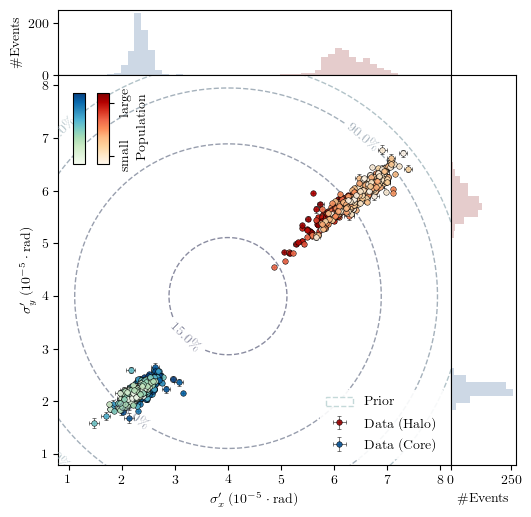

In [63]:
figsize =  (5.905631659056317, 5.905631659056317)
# figsize = (7,7)

fig, ax= plt.subplots(2,2, figsize=figsize, gridspec_kw=Dict("width_ratios"=>[6,1], "height_ratios"=>[1,6]))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

colors_tmp = [plt.cm.bone_r(i) for i in range(0.1, stop=0.6, length=length(levels))[2:end]]
cs = ax[2,1].contour(xrange, yrange, z./sum(z), levels=levels, colors=colors_tmp, alpha=0.7, antialiased=true, linewidths=1.0, linestyles="dashed") 


label_1 = "Data (Halo)"
label_2 = "Data (Core)"

errorbar_ind = rind[1]:2:rind[end]
for i in rind[end:-1:1]
    x_err = i in errorbar_ind ? std_x_halo[i] : false
    y_err = i in errorbar_ind ? std_y_halo[i] : false
    ax[2,1].errorbar(σ_x_halo[i], σ_y_halo[i], xerr=x_err, yerr=y_err, 
        color="k", alpha=0.9,
        fmt="o", markersize=4, 
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.4,
        capsize=1.5, ecolor="k", elinewidth=0.4, label=label_1)
    label_1 = ""
    x_err = i in errorbar_ind ? std_x_core[i] : false
    y_err = i in errorbar_ind ? std_y_core[i] : false
    ax[2,1].errorbar(σ_x_core[i], σ_y_core[i], xerr=x_err, yerr=y_err, 
        color="k", alpha=0.9,
        fmt="o", markersize=4,
        mfc=plt.cm.GnBu(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.4, 
        capsize=1.5, ecolor="k", elinewidth=0.4, label=label_2)
    label_2 = ""
end

cb = ax[2,1].scatter(charges_n, charges_n, s=0.0, c=charges, cmap="OrRd")
cb2 = ax[2,1].scatter(charges_n, charges_n, s=0.0, c=charges, cmap="GnBu")
ax_ins_3 = fig.add_axes([0.19,0.62,0.02,0.12])
ax_ins_2 = fig.add_axes([0.15,0.62,0.02,0.12])
cbar = fig.colorbar(cb, spacing="proportional", label="Population", ticks = [10, 25], cax=ax_ins_3)
cbar.ax.set_yticklabels(["small", "large"], rotation=90, verticalalignment="center")  # horizontal colorbar
fig.colorbar(cb2, spacing="proportional", ticks=[], cax=ax_ins_2)

proxy = plt.Rectangle((10, 10), 1, 1, fc="white", color=plt.cm.bone_r(0.17), linewidth=1.0, linestyle="dashed", label="Prior")
# proxy2 = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.Blues(0.57), label="Posterior LC")
# proxy3 = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.Greens(0.57), label="Posterior SC")
ax[2,1].add_patch(proxy)
# ax[2,1].add_patch(proxy2)
# ax[2,1].add_patch(proxy3)


bins_tmp = range(0.8, stop=7.2, length=50)
ax[1,1].hist(σ_x_halo, bins=bins_tmp, color=plt.cm.OrRd(1.), alpha=0.20)
ax[2,2].hist(σ_y_halo, bins=bins_tmp, orientation="horizontal", color=plt.cm.OrRd(1.), alpha=0.2)
ax[1,1].hist(σ_x_core, bins=bins_tmp, color=plt.cm.GnBu(1.), alpha=0.20)
ax[2,2].hist(σ_y_core, bins=bins_tmp, orientation="horizontal", color=plt.cm.GnBu(1.), alpha=0.20)


ax[1,1].set_ylim(bottom=0.0)
ax[2,2].set_xlim(left=0.0)

ax[1,2].set_visible(false)

ax[1,1].set_xticks([])
ax[2,2].set_yticks([])

ax[2,1].set_xlim(0.8, 8.2)
ax[1,1].set_xlim(0.8, 8.2)
ax[2,1].set_ylim(0.8, 8.2)
ax[2,2].set_ylim(0.8, 8.2)

ax[2,1].clabel(cs, fmt = Dict(zip(levels, level_labels)), inline = 1);

ax[2,1].legend(loc="lower right", framealpha=0.9, edgecolor=:white)

ax[2,1].set_xlabel(L"\sigma'_x \; (\mathrm{10^{-5} \cdot rad})")
ax[2,2].set_xlabel(L"\mathrm{\# Events}")
ax[2,1].set_ylabel(L"\sigma'_y \; (\mathrm{10^{-5} \cdot rad})")
ax[1,1].set_ylabel(L"\mathrm{\# Events}")

fig.savefig("../../plots/ang-spread-m-2.pdf", bbox_inches = "tight")

## Waist Positions: 

In [127]:
halo_waist = data.μ_waist_halo
core_waist = data.μ_waist_core

halo_std = data.σ_waist_halo
core_std = data.σ_waist_core;

In [128]:
xmin, xmax = 2.5, 3.6
xrange=range(xmin, stop = xmax,length=300)
yrange=range(xmin, stop = xmax,length=300)

xvals = diff(cdf.(Normal(2.774, 0.03), xrange))
yvals = diff(cdf.(Normal(2.774, 0.03), yrange))

# xvals = [pdf(Normal(2.774, 0.03), x) for x in xrange] #truncated(Normal(2.774, 0.03), 2.5, 3.6)
# yvals = [pdf(Normal(2.774, 0.03), y)  for y in yrange]
z = xvals*yvals';

In [129]:
quantiles_array = [0.0, 0.1, 0.68, 0.999, 1]

levels, level_labels = get_quantiles(z./sum(z), quantiles_array);

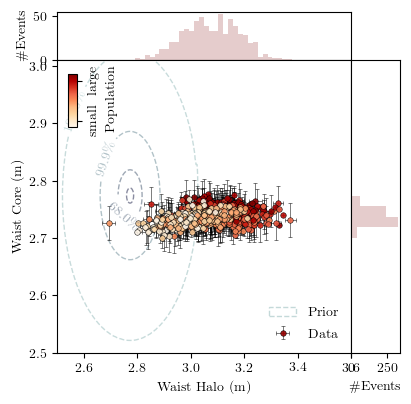

In [132]:
figsize = (4.429223744292238, 4.429223744292238)
# figsize = (7,7)

fig, ax= plt.subplots(2,2, figsize=figsize, gridspec_kw=Dict("width_ratios"=>[6,1], "height_ratios"=>[1,6]))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

colors_tmp = [plt.cm.bone_r(i) for i in range(0.1, stop=0.6, length=length(levels))[2:end]]
cs = ax[2,1].contour(midpoints(xrange), midpoints(yrange), z./sum(z), levels=levels, colors=colors_tmp, alpha=0.7, antialiased=true, linewidths=1.0, linestyles="dashed") 

label_1 = "Data"

errorbar_ind = rind[1]:3:rind[end]
for i in rind[end:-1:1]
    x_err = i in errorbar_ind ? halo_std[i] : false
    y_err = i in errorbar_ind ? core_std[i] : false
    ax[2,1].errorbar(halo_waist[i], core_waist[i], xerr=x_err, yerr=y_err, 
        color="k", alpha=0.9,
        fmt="o", markersize=4, 
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.4,
        capsize=1.5, ecolor="k", elinewidth=0.4, label=label_1)
    label_1 = ""

end

cb = ax[2,1].scatter(charges_n, charges_n, s=0.0, c=charges, cmap="OrRd")
ax_ins_3 = fig.add_axes([0.15,0.62,0.02,0.12])
cbar = fig.colorbar(cb, spacing="proportional", label="Population", ticks = [10, 25], cax=ax_ins_3)
cbar.ax.set_yticklabels(["small", "large"], rotation=90, verticalalignment="center")  # horizontal colorbar

proxy = plt.Rectangle((10, 10), 1, 1, fc="white", color=plt.cm.bone_r(0.17), linewidth=1.0, linestyle="dashed", label="Prior")
ax[2,1].add_patch(proxy)

bins_tmp = range(2.7, stop=3.6, length=50)
ax[1,1].hist(halo_waist, bins=bins_tmp, color=plt.cm.OrRd(1.), alpha=0.20)
ax[2,2].hist(core_waist, bins=bins_tmp, orientation="horizontal", color=plt.cm.OrRd(1.), alpha=0.2)


ax[1,1].set_ylim(bottom=0.0)
ax[2,2].set_xlim(left=0.0)

ax[1,2].set_visible(false)

ax[1,1].set_xticks([])
ax[2,2].set_yticks([])

ax[2,1].set_xlim(xmin, xmax)
ax[1,1].set_xlim(xmin, xmax)
ax[2,1].set_ylim(xmin, 3.01)
ax[2,2].set_ylim(xmin, 3.01)

ax[2,1].clabel(cs, fmt = Dict(zip(levels, level_labels)), inline = 1);

ax[2,1].legend(loc="lower right", framealpha=0.9, edgecolor=:white)

ax[2,1].set_xlabel("Waist Halo (m)")
ax[2,2].set_xlabel(L"\mathrm{\# Events}")
ax[2,1].set_ylabel("Waist Core (m)")
ax[1,1].set_ylabel(L"\mathrm{\# Events}")

fig.savefig("../../plots/waist-m-2.pdf", bbox_inches = "tight")

## Emittance: 

In [120]:
em_x_halo = data.μx_emitt_halo
em_y_halo = data.μy_emitt_halo
em_x_core = data.μx_emitt_core
em_y_core = data.μy_emitt_core

std_x_halo = data.σx_emitt_halo
std_y_halo = data.σy_emitt_halo
std_x_core = data.σx_emitt_core
std_y_core = data.σy_emitt_core;

In [124]:
prior_emmitance_x = rand(Normal(0.2, 0.04), 10^7) .* rand(Normal(4, 2), 10^7) .* 10^-5 .* 1000 .* 426.0
prior_emmitance_y = rand(Normal(0.2, 0.04), 10^7) .* rand(Normal(4, 2), 10^7) .* 10^-5 .* 1000 .* 426.0

hist_em_tmp = fit(Histogram, (prior_emmitance_x,prior_emmitance_y),nbins=120)
hist_em_tmp = normalize(hist_em_tmp, mode=:pdf);

range_tmp = range(1.2*minimum(hist_em_tmp.weights), stop=maximum(hist_em_tmp.weights), length=10)[2:end]
colors_tmp = [plt.cm.bone_r(i) for i in range(0, stop=0.4, length=length(range_tmp))[2:end]];

In [125]:
quantiles_array = [0.0, 0.05, 0.1, 0.22, 0.35, 0.50, 0.7, 1]

levels, level_labels = get_quantiles(hist_em_tmp.weights./sum(hist_em_tmp.weights), quantiles_array);

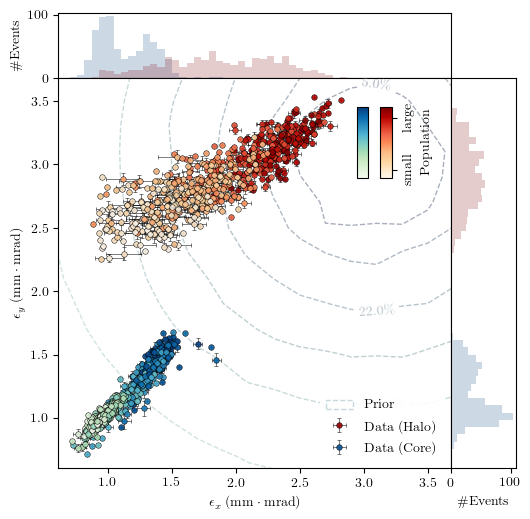

In [126]:
figsize = (5.905631659056317, 5.905631659056317)
# figsize = (7,7)

fig, ax= plt.subplots(2,2, figsize=figsize, gridspec_kw=Dict("width_ratios"=>[6,1], "height_ratios"=>[1,6]))
fig.subplots_adjust(hspace=0.0, wspace=0.0)

# ax[2,1].contourf(midpoints(hist_em_tmp.edges[1]), midpoints(hist_em_tmp.edges[2]), hist_em_tmp.weights', levels=range_tmp, colors=colors_tmp, alpha=0.3, antialiased=true) 

colors_tmp = [plt.cm.bone_r(i) for i in range(0.1, stop=0.5, length=length(levels))[2:end]]


label_1 = "Data (Halo)"
label_2 = "Data (Core)"

errorbar_ind = rind[1]:3:rind[end]
for i in rind[end:-1:1]
    x_err = i in errorbar_ind ? std_x_halo[i] : false
    y_err = i in errorbar_ind ? std_y_halo[i] : false
    ax[2,1].errorbar(em_x_halo[i], em_y_halo[i], xerr=x_err, yerr=y_err, 
        color="k", alpha=0.9,
        fmt="o", markersize=4, 
        mfc=plt.cm.OrRd(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.4,
        capsize=1.5, ecolor="k", elinewidth=0.4, label=label_1)
    label_1 = ""
    x_err = i in errorbar_ind ? std_x_core[i] : false
    y_err = i in errorbar_ind ? std_y_core[i] : false
    ax[2,1].errorbar(em_x_core[i], em_y_core[i], xerr=x_err, yerr=y_err, 
        color="k", alpha=0.9,
        fmt="o", markersize=4,
        mfc=plt.cm.GnBu(charges_n[i]), #red
        markeredgecolor = "k", markeredgewidth=0.4, 
        capsize=1.5, ecolor="k", elinewidth=0.4, label=label_2)
    label_2 = ""
end

cb = ax[2,1].scatter(charges_n, charges_n, s=0.0, c=charges, cmap="OrRd")
cb2 = ax[2,1].scatter(charges_n, charges_n, s=0.0, c=charges, cmap="GnBu")
ax_ins_3 = fig.add_axes([0.67,0.60,0.02,0.12])
ax_ins_2 = fig.add_axes([0.63,0.60,0.02,0.12])
cbar = fig.colorbar(cb, spacing="proportional", label="Population", ticks = [10, 25], cax=ax_ins_3)
cbar.ax.set_yticklabels(["small", "large"], rotation=90, verticalalignment="center")  # horizontal colorbar
fig.colorbar(cb2, spacing="proportional", ticks=[], cax=ax_ins_2)

proxy = plt.Rectangle((10, 10), 1, 1, fc="white", color=plt.cm.bone_r(0.17), linewidth=1.0, linestyle="dashed", label="Prior")
# proxy2 = plt.Rectangle((10, 10), 1, 1, fc=plt.cm.Blues(0.57), label="Posterior")
ax[2,1].add_patch(proxy)
# ax[2,1].add_patch(proxy2)
ax[2,1].legend(loc="lower right")

bins_tmp = range(0.7, stop=3.5, length=50)
ax[1,1].hist(em_x_core, bins=bins_tmp, color=plt.cm.GnBu(1.0), alpha=0.20)
ax[2,2].hist(em_y_core, bins=bins_tmp, orientation="horizontal", color=plt.cm.GnBu(1.0), alpha=0.20)
ax[1,1].hist(em_x_halo, bins=bins_tmp, color=plt.cm.OrRd(1.0), alpha=0.20)
ax[2,2].hist(em_y_halo, bins=bins_tmp, orientation="horizontal", color=plt.cm.OrRd(1.0), alpha=0.20)

ax[1,1].set_ylim(bottom=0.0)
ax[2,2].set_xlim(left=0.0)

ax[1,2].set_visible(false)

ax[1,1].set_xticks([])
ax[2,2].set_yticks([])

ax[2,1].set_xlim(0.61, 3.68)
ax[1,1].set_xlim(0.61, 3.68)
ax[2,1].set_ylim(0.61, 3.68)
ax[2,2].set_ylim(0.61, 3.68)

cs = ax[2,1].contour(
    midpoints(hist_em_tmp.edges[1]),
    midpoints(hist_em_tmp.edges[2]), 
    (hist_em_tmp.weights./sum(hist_em_tmp.weights))', 
    levels=levels, colors=colors_tmp, alpha=0.6, antialiased=true, linewidths=1.0, linestyles="dashed") 

ax[2,1].clabel(cs, fmt = Dict(zip(levels, level_labels)), inline = 1)

ax[2,1].legend(loc="lower right", framealpha=0.9, edgecolor=:white)

ax[2,1].set_xlabel(L"\epsilon_x \; (\mathrm{mm \cdot mrad})")
ax[2,2].set_xlabel(L"\mathrm{\# Events}")
ax[2,1].set_ylabel(L"\epsilon_y \; (\mathrm{mm \cdot mrad})")
ax[1,1].set_ylabel(L"\mathrm{\# Events}")

fig.savefig("../../plots/em-m-2.pdf", bbox_inches = "tight")

## Alignment: 

In [138]:
μx = data.μx_align
μy = data.μy_align;

In [139]:
fig, ax= plt.subplots(2,2, figsize=(6,6),)
fig.subplots_adjust(hspace=0.07, wspace=0.07)

label = "Mean + Std"

ax[1,1].scatter([μ[1] for μ in μx], [μ[1] for μ in μy], c=plt.cm.OrRd(runind_n), marker="o", s = 20, edgecolors="k", linewidths=0.5, label=label)
ax[1,2].scatter([μ[2] for μ in μx], [μ[2] for μ in μy], c=plt.cm.OrRd(runind_n), marker="o", s = 20, edgecolors="k", linewidths=0.5, )
ax[2,1].scatter([μ[3] for μ in μx], [μ[3] for μ in μy], c=plt.cm.OrRd(runind_n), marker="o", s = 20, edgecolors="k", linewidths=0.5, )
ax[2,2].scatter([μ[4] for μ in μx], [μ[4] for μ in μy], c=plt.cm.OrRd(runind_n), marker="o", s = 20, edgecolors="k", linewidths=0.5, )

cb = ax[3].scatter(charges_n, charges_n, s=0.0, c=data.ev_index, cmap="OrRd")
ax_ins_3 = fig.add_axes([0.79,0.77,0.01,0.1])
fig.colorbar(cb, spacing="proportional", label="Event #", cax=ax_ins_3)

ax[1,1].xaxis.tick_top()
ax[1,1].xaxis.set_ticks_position("top")

ax[1,2].xaxis.tick_top()
ax[1,2].xaxis.set_ticks_position("top")
ax[1,2].yaxis.tick_right()
ax[1,2].yaxis.set_ticks_position("right")

ax[2,2].yaxis.tick_right()
ax[2,2].yaxis.set_ticks_position("right")

ax[1,1].text(0.04,0.91,"Cam. #1", transform=ax[1,1].transAxes)
ax[1,2].text(0.04,0.91,"Cam. #2", transform=ax[1,2].transAxes)
ax[2,1].text(0.04,0.91,"Cam. #3", transform=ax[2,1].transAxes)
ax[2,2].text(0.04,0.91,"Cam. #4", transform=ax[2,2].transAxes)

ax[1,1].set_xlim(-5,310)
ax[1,1].set_ylim(-5,310)

ax[1,2].set_xlim(-5,310)
ax[1,2].set_ylim(-5,310)

ax[2,1].set_xlim(-5,310)
ax[2,1].set_ylim(-5,310)

ax[2,2].set_xlim(-5,310)
ax[2,2].set_ylim(-5,310)
# ax[2,2].set_ylim(34.2,37)

ax[2,2].set_xlabel(L"\mu_x \; \mathrm{(\mu m)}")
ax[2,1].set_xlabel(L"\mu_x \; \mathrm{(\mu m)}")

ax[1,1].set_ylabel(L"\mu_y \; \mathrm{(\mu m)}")
ax[2,1].set_ylabel(L"\mu_y \; \mathrm{(\mu m)}")

Figure(PyObject <Figure size 600x600 with 5 Axes>)

PyObject Text(0, 0.5, '$\\mu_y \\; \\mathrm{(\\mu m)}$')

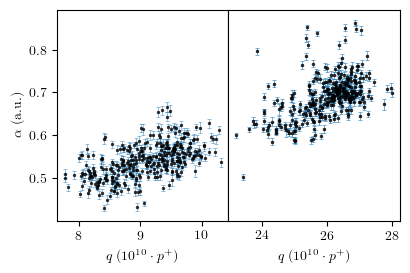

In [205]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(4.429223744292238, 2.737410817750676), sharey=true)

fig.subplots_adjust(hspace=0.00, wspace=0.00)

ax.errorbar(data.ev_charge[data.mode .== "SP"], data.μmixt_pow[data.mode .== "SP"], yerr=data.σmixt_pow[data.mode .== "SP"],  
        color="k", alpha=0.8,
        fmt="o", markersize=2, 
        markeredgecolor = "k", markeredgewidth=0.4,
        capsize=1.5, ecolor="C0", elinewidth=0.4) 

ax2.errorbar(data.ev_charge[data.mode .== "LP"], data.μmixt_pow[data.mode .== "LP"], yerr=data.σmixt_pow[data.mode .== "LP"],  
        color="k", alpha=0.8,
        fmt="o", markersize=2, 
        markeredgecolor = "k", markeredgewidth=0.5,
        capsize=1.5, ecolor="C0", elinewidth=0.5) 

# ax2.yaxis.set_label_position("right")
# ax2.yaxis.tick_right()

ax2.tick_params(axis="y", which="both",
                left=false)


ax.set_xlabel(L"q \; (10^{10}\cdot p^+)")
ax.set_ylabel(L"\alpha \; \textup{(a.u.)}")
ax2.set_xlabel(L"q \; (10^{10}\cdot p^+)")

# fig.savefig("../../plots/alpha.pdf", bbox_inches = "tight")

## Covariance: 

In [136]:
ind = [1,2,4,5,6,7,8,9,10,11,12,13,14,15, 16,17,18]
mat_data = hcat([data[i] for i in ind]...)'
mat_data = mat_data ./ std(mat_data, dims=2)
cv = mat_data .- mean(mat_data, dims=2)
cv = cov(cv');

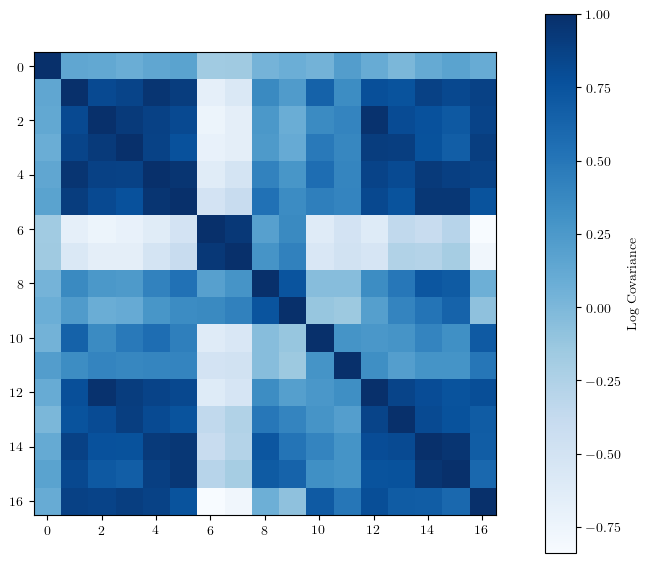

In [137]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(7,7), gridspec_kw=Dict("width_ratios"=>[15,1]))

max = maximum(abs.(cv))

cb = ax.imshow(cv,  origin="upper", cmap="Blues", aspect="equal") 
fig.colorbar(cb, spacing="proportional", label="Log Covariance", cax=ax2)

# ax.set_yticks(0:26)
# ax.set_yticklabels(labels)

# ax.set_xticks(0:26)
# ax.set_xticklabels(labels, rotation = 90);